# Example: Optimization of a Perfectly Entangling Quantum gate

$
\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
$

## Two Transmon qubits with a shared transmission line

 ![Two transmons with a shared transmission line](transmon.png)

### Hamiltonian

The energies system energies are on the order of GHz (angular frequency; the factor
2π is implicit), with dynamics on the order of ns

In [1]:
const GHz = 2π
const MHz = 0.001GHz
const ns = 1.0
const μs = 1000ns;
⊗ = kron;
const 𝕚 = 1im;

We truncated the Hamiltonian to $N$ levels

In [2]:
const N = 6;  # levels per transmon

So the dimension of the total Hilbert space is $N^2 = 36$

The Hamiltonian and parameters are taken from
[Goerz *et al.*, Phys. Rev. A 91, 062307 (2015); Table 1](https://michaelgoerz.net/#GoerzPRA2015).

In [3]:
using LinearAlgebra
using SparseArrays
using QuantumControl: hamiltonian

function transmon_hamiltonian(;
    Ωre, Ωim, N=N, ω₁=4.380GHz, ω₂=4.614GHz, ωd=4.498GHz, α₁=-210MHz,
    α₂=-215MHz, J=-3MHz, λ=1.03,
)
    𝟙 = SparseMatrixCSC{ComplexF64,Int64}(sparse(I, N, N))
    b̂₁ = spdiagm(1 => complex.(sqrt.(collect(1:N-1)))) ⊗ 𝟙
    b̂₂ = 𝟙 ⊗ spdiagm(1 => complex.(sqrt.(collect(1:N-1))))
    b̂₁⁺ = sparse(b̂₁'); b̂₂⁺ = sparse(b̂₂')
    n̂₁ = sparse(b̂₁' * b̂₁); n̂₂ = sparse(b̂₂' * b̂₂)
    n̂₁² = sparse(n̂₁ * n̂₁); n̂₂² = sparse(n̂₂ * n̂₂)
    b̂₁⁺_b̂₂ = sparse(b̂₁' * b̂₂); b̂₁_b̂₂⁺ = sparse(b̂₁ * b̂₂')

    # rotating frame: ω₁, ω₂ → detuning; driving field Ω ∈ ℂ
    ω̃₁ = ω₁ - ωd; ω̃₂ = ω₂ - ωd

    Ĥ₀ = sparse(
        (ω̃₁ - α₁ / 2) * n̂₁ +
        (α₁ / 2) * n̂₁² +
        (ω̃₂ - α₂ / 2) * n̂₂ +
        (α₂ / 2) * n̂₂² +
        J * (b̂₁⁺_b̂₂ + b̂₁_b̂₂⁺)
    )
    Ĥ₁re = sparse((1 / 2) * (b̂₁ + b̂₁⁺ + λ * b̂₂ + λ * b̂₂⁺))
    Ĥ₁im = sparse((𝕚 / 2) * (b̂₁⁺ - b̂₁ + λ * b̂₂⁺ - λ * b̂₂))
    return hamiltonian(Ĥ₀, (Ĥ₁re, Ωre), (Ĥ₁im, Ωim))
end;

...

### Initial driving field

In [4]:
using QuantumControl.Amplitudes: ShapedAmplitude
using QuantumControl.Shapes: flattop

function guess_amplitudes(; T=400ns, E₀=35MHz, dt=0.1ns, t_rise=15ns)
    tlist = collect(range(0, T, step=dt))
    shape(t) = flattop(t, T=T, t_rise=t_rise)
    Ωre = ShapedAmplitude(t -> E₀, tlist; shape)
    Ωim = ShapedAmplitude(t -> 0.0, tlist; shape)
    return tlist, Ωre, Ωim
end

tlist, Ωre_guess, Ωim_guess = guess_amplitudes();

In [5]:
include("includes/plot_complex_pulse.jl")

plot_complex_pulse (generic function with 1 method)

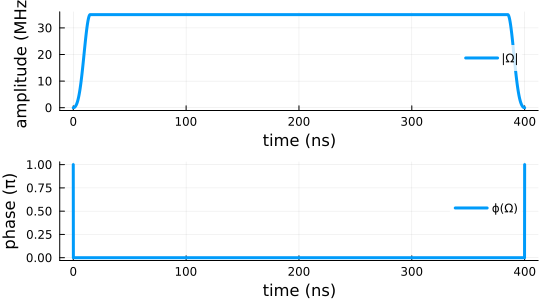

In [6]:
plot_complex_pulse(tlist, Array(Ωre_guess))

In [7]:
H = transmon_hamiltonian(Ωre=Ωre_guess, Ωim=Ωim_guess);

### Logical basis

In [8]:
function ket(i::Int64; N=N)
    Ψ = zeros(ComplexF64, N)
    Ψ[i+1] = 1
    return Ψ
end

function ket(indices::Int64...; N=N)
    Ψ = ket(indices[1]; N=N)
    for i in indices[2:end]
        Ψ = Ψ ⊗ ket(i; N=N)
    end
    return Ψ
end

function ket(label::AbstractString; N=N)
    indices = [parse(Int64, digit) for digit in label]
    return ket(indices...; N=N)
end;

In [9]:
basis = [ket("00"), ket("01"), ket("10"), ket("11")];

In [10]:
ket("01")

36-element Vector{ComplexF64}:
 0.0 + 0.0im
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

## Dynamics of the guess field

In [11]:
using QuantumControl: propagate

...

In [12]:
logical_overlap = [(Ψ -> Ψ ⋅ ϕ) for ϕ ∈ basis];

In [13]:
dyn00 = propagate(ket("00"), H , tlist; observables=logical_overlap, storage=true)
dyn01 = propagate(ket("01"), H , tlist; observables=logical_overlap, storage=true)
dyn10 = propagate(ket("10"), H , tlist; observables=logical_overlap, storage=true)
dyn11 = propagate(ket("11"), H , tlist; observables=logical_overlap, storage=true)

4×4001 Matrix{ComplexF64}:
 0.0+0.0im  -2.39717e-38+6.02033e-41im  …    -0.235051+0.0535181im
 0.0+0.0im   5.01846e-21-1.52469e-19im     -0.00751948+0.0103133im
 0.0+0.0im  -6.35138e-21-1.56991e-19im     -0.00120914-0.00378444im
 1.0+0.0im      0.999992-0.00125631im         0.549798-0.644815im

We concatenate the columns to get the $4 \times 4$ matrix U that is that "gate" in the two-qubit subspace at each point in time:

In [14]:
U_of_t = [[dyn00[:,n] dyn01[:,n] dyn10[:,n] dyn11[:,n]] for n = 1:length(tlist)];

In [15]:
using TwoQubitWeylChamber: gate_concurrence, unitarity

The `gate_concurrence` is the amount of entanglement that can be generated by applying the gate to a separable input state.

A well-known perfectly entangling gate is the controlled-NOT gate:

In [16]:
CNOT = [
    1 0 0 0
    0 1 0 0
    0 0 0 1
    0 0 1 0
];

In [17]:
gate_concurrence(CNOT)

1.0

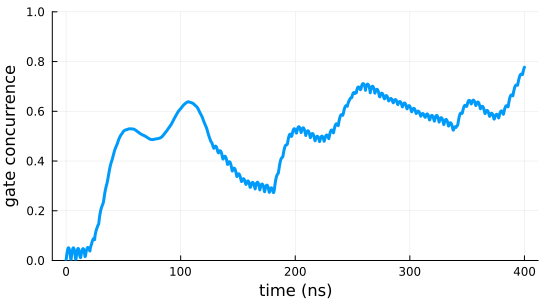

In [18]:
plot(tlist, gate_concurrence.(U_of_t), xlabel="time (ns)", ylabel="gate concurrence", label="", ylim=(0, 1))

In [19]:
gate_concurrence(U_of_t[end])

0.7773116198514517

Our guess pulse does not result in a perfectly entangling gate.

Moreover, there is loss of population from the logical subspace, i.e., the $4 \times 4$ matrices in `U_of_t` are not unitary:

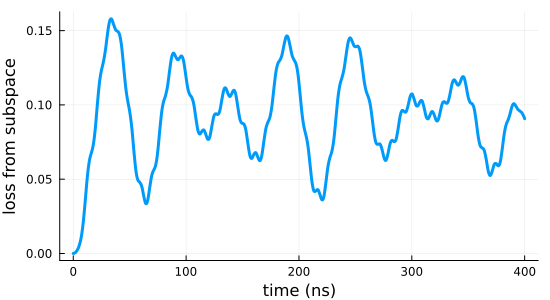

In [20]:
plot(tlist, 1 .- unitarity.(U_of_t), xlabel="time (ns)", ylabel="loss from subspace", label="")

In [21]:
1 - unitarity(U_of_t[end])

0.09071664593801598

## Maximization of Gate Concurrence

In [22]:
using QuantumControl: Objective

objectives = [Objective(; initial_state=Ψ, generator=H) for Ψ ∈ basis];

In [23]:
J_T_C = U -> 0.5 * (1 - gate_concurrence(U)) + 0.5 * (1 - unitarity(U));

In [24]:
J_T_C(U_of_t[end])

0.15670251304328214

In [25]:
using QuantumControl.Functionals: gate_functional

J_T = gate_functional(J_T_C);

$J_T$ is now a function of the propagated states $\ket{\Psi_{00}(T)}$, $\ket{\Psi_{01}(T)}$, $\ket{\Psi_{10}(T)}$, $\ket{\Psi_{11}(T)}$.

...

In [26]:
using QuantumControl.Functionals: make_gate_chi

chi = make_gate_chi(J_T_C, objectives)

(::QuantumControl.Functionals.var"#zygote_gate_chi!#35"{QuantumControl.Functionals.var"#zygote_gate_chi!#29#36"{Bool, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, var"#24#25", Vector{Vector{ComplexF64}}, Int64}}) (generic function with 1 method)

In [27]:
using QuantumControl: ControlProblem

problem = ControlProblem(;
    objectives, tlist, J_T, chi,
    check_convergence=res -> begin
        (
            (res.J_T <= 1e-3) &&
            (res.converged = true) &&
            (res.message = "Found a perfect entangler")
        )
    end,
    use_threads=true,
);

In [28]:
using QuantumControl: optimize

res = optimize(problem; method=:GRAPE)

 iter.        J_T     |∇J_T|       ΔJ_T   FG(F)    secs
     0   1.57e-01   1.42e-01        n/a    1(0)    19.6
     1   1.46e-01   3.18e-01  -1.05e-02    1(0)     0.4
     2   1.30e-01   2.86e-01  -1.61e-02    1(0)     0.3
     3   8.10e-02   2.10e-01  -4.91e-02    2(0)     0.5
     4   7.66e-02   3.79e-01  -4.41e-03    1(0)     0.2
     5   4.89e-02   1.87e-01  -2.77e-02    1(0)     0.2
     6   2.64e-02   2.11e-01  -2.25e-02    1(0)     0.2
     7   7.54e-03   1.09e-01  -1.89e-02    1(0)     0.3
     8   5.86e-03   1.98e-01  -1.68e-03    1(0)     0.5
     9   3.00e-03   4.01e-02  -2.87e-03    1(0)     0.3
    10   2.71e-03   2.72e-02  -2.88e-04    1(0)     0.3
    11   2.21e-03   2.82e-02  -5.01e-04    1(0)     0.3
    12   1.42e-03   2.46e-02  -7.84e-04    1(0)     0.3
    13   3.24e-04   2.83e-02  -1.10e-03    1(0)     0.3


GRAPE Optimization Result
-------------------------
- Started at 2023-07-30T17:34:33.385
- Number of objectives: 4
- Number of iterations: 13
- Number of pure func evals: 0
- Number of func/grad evals: 15
- Value of functional: 3.24322e-04
- Reason for termination: Found a perfect entangler
- Ended at 2023-07-30T17:34:57.011 (23 seconds, 626 milliseconds)


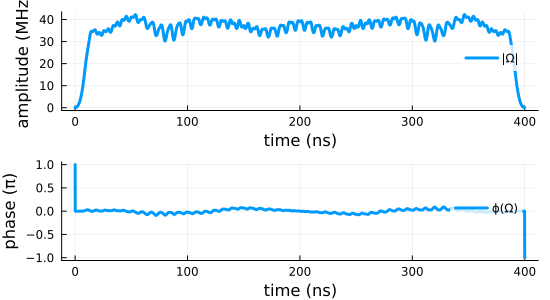

In [29]:
ϵ_opt = res.optimized_controls[1] + 𝕚 * res.optimized_controls[2]
Ω_opt = ϵ_opt .* discretize(Ωre_guess.shape, tlist)

plot_complex_pulse(tlist, Ω_opt)

## Dynamics of the optimized field

In [30]:
using QuantumControl.Controls: get_controls

ϵ_re_guess, ϵ_im_guess = get_controls(H);

In [31]:
using QuantumControl.Controls: substitute

H_opt = substitute(
    H,
    IdDict(
        ϵ_re_guess => res.optimized_controls[1],
        ϵ_im_guess => res.optimized_controls[2]
    )
);

In [32]:
dyn00_opt = propagate(ket("00"), H_opt , tlist; observables=logical_overlap, storage=true)
dyn01_opt = propagate(ket("01"), H_opt , tlist; observables=logical_overlap, storage=true)
dyn10_opt = propagate(ket("10"), H_opt , tlist; observables=logical_overlap, storage=true)
dyn11_opt = propagate(ket("11"), H_opt , tlist; observables=logical_overlap, storage=true)
U_opt_of_t = [[dyn00_opt[:,n] dyn01_opt[:,n] dyn10_opt[:,n] dyn11_opt[:,n]] for n = 1:length(tlist)];

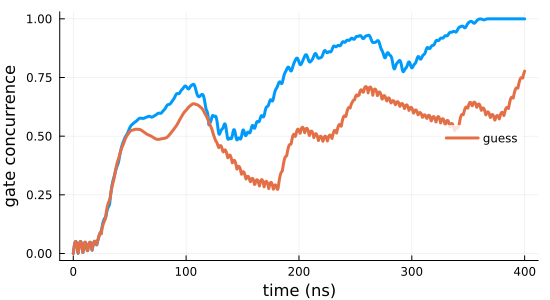

In [33]:
plot(tlist, gate_concurrence.(U_opt_of_t), xlabel="time (ns)", ylabel="gate concurrence", label="")
plot!(tlist, gate_concurrence.(U_of_t), label="guess")

In [34]:
gate_concurrence(U_opt_of_t[end])

1.0

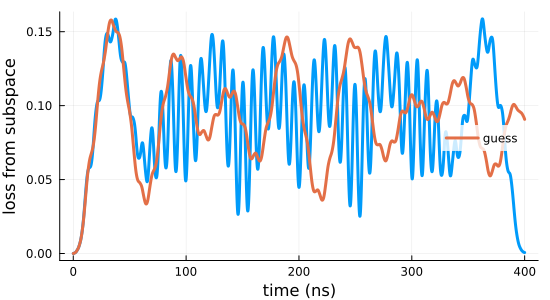

In [35]:
plot(tlist, 1 .- unitarity.(U_opt_of_t), xlabel="time (ns)", ylabel="loss from subspace", label="")
plot!(tlist, 1 .- unitarity.(U_of_t), label="guess")

In [36]:
1 - unitarity(U_opt_of_t[end])

0.0006486436950214891